# 使用 CNN 进行命名实体识别

## 导入相关模块并设置一些参数

In [1]:
import numpy as np
import mxnet as mx
import collections
import time
import os

from mxnet import autograd, gluon, nd
from mxnet.gluon import nn, rnn, Block
from mxnet.contrib import text
from sklearn import metrics
from sklearn.model_selection import train_test_split
from io import open

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PAD = '<PAD>'
NOT = 'N'
PAD_NATURE = 'r'

In [3]:
epochs = 10
drop_prob = 0.2
batch_size = 256
learning_rate = 0.01

max_seq_len = 30

word_vec_size = 200
nature_vec_size = 50
distance_vec_size = 50
num_channels = 10
conv_width = word_vec_size + nature_vec_size + distance_vec_size
kernels_size_ls = [(2, conv_width), (3, conv_width), (4, conv_width)]
padding_ls = None
pool_size = (2, 1) 
output_size = 6
distance_size = 2 * max_seq_len - 1

test_size_por = 0.1

ctx = mx.gpu()

## 定义一些辅助函数

In [4]:
def read_data(max_seq_len):
    """读取数据"""
    input_tokens = []   # 记录输入 X 的所有词，包含重复
    output_tokens = []  # 记录输出 Y 的所有符号，包含重复
    nature_tokens = []  # 记录所有词的词性的符号，包含重复
    input_seqs = []  # 列表中装的列表，里面的每个列表代表一条输入，填充或截断好了的
    output_seqs = []  # 同input_seqs
    nature_seqs = []
    
    with open("../data_for_seq2seq/re_cut_lines_word.txt", 'r') as fx, open("../data_for_seq2seq/re_cut_lines_label.txt", 'r') as fy, open("../data_for_seq2seq/re_cut_lines_nature.txt", 'r') as fn:
        word_lines = fx.readlines()
        label_lines = fy.readlines()
        word_natures = fn.readlines()
        
        for word_line, lable_line, word_nature in zip(word_lines, label_lines, word_natures):
            
            input_seq = word_line.strip()
            output_seq = lable_line.strip()
            nature_seq = word_nature.strip()
            
            cur_input_tokens = input_seq.split(' ')
            cur_output_tokens = output_seq.split(' ')
            cur_nature_tokens = nature_seq.split(' ')
            
            if '' in cur_output_tokens:
                continue
            
            if len(cur_input_tokens) < max_seq_len or len(cur_output_tokens) < max_seq_len or len(cur_nature_tokens) < max_seq_len:
                input_tokens.extend(cur_input_tokens)
                output_tokens.extend(cur_output_tokens)
                nature_tokens.extend(cur_nature_tokens)
                
                # 添加 PAD 符号使每个序列等长，长度为 max_seq_len
                while len(cur_input_tokens) < max_seq_len:
                    cur_input_tokens.append(PAD)
                    # 把输出也填充到了最大长度
                    cur_output_tokens.append(NOT)
                    cur_nature_tokens.append(PAD_NATURE)
                    
                input_seqs.append(cur_input_tokens)                            
                output_seqs.append(cur_output_tokens)
                nature_seqs.append(cur_nature_tokens)
                
            else:
                cur_input_tokens = cur_input_tokens[0: max_seq_len]
                cur_output_tokens = cur_output_tokens[0: max_seq_len]
                cur_nature_tokens = cur_nature_tokens[0: max_seq_len]
                
                input_tokens.extend(cur_input_tokens)
                input_seqs.append(cur_input_tokens)
                
                output_tokens.extend(cur_output_tokens)
                output_seqs.append(cur_output_tokens)
                
                nature_tokens.extend(cur_nature_tokens)
                nature_seqs.append(cur_nature_tokens)
                
        fr_vocab = text.vocab.Vocabulary(collections.Counter(input_tokens), reserved_tokens=[PAD])
        print(collections.Counter(output_tokens))
        en_vocab = text.vocab.Vocabulary(collections.Counter(output_tokens))
        
        nature_vocab = text.vocab.Vocabulary(collections.Counter(nature_tokens))
    
    return fr_vocab, en_vocab, nature_vocab, input_seqs, output_seqs, nature_seqs

In [5]:
def generate_cnn_input(word_data, nature, batch_distance, pos):
    """生成满足模型的输入"""
    x_input = word_data[:, pos]
    nature_input = nature[:, pos]
    distance_input = batch_distance[:, pos]
    
    return x_input, nature_input, distance_input   

In [6]:
def cal_scores(y_hat, label):
    """计算结果的评分指标"""
    # 将预测结果与真实标记都变为一维数组以方便计算
    y_hat = y_hat.reshape((-1, ))
    label = label.reshape((-1, ))
    # average 置为 None，可以返回每个类别的 P R F
    p = metrics.precision_score(label, y_hat, average=None)
    r = metrics.recall_score(label, y_hat, average=None)
    f1 = metrics.f1_score(label, y_hat, average=None)
    return p, r, f1

## 数据的预处理

In [7]:
input_vocab, output_vocab, nature_vocab, input_seqs, output_seqs, nature_seqs = read_data(max_seq_len)

Counter({'N': 7739104, 'C': 626209, 'B': 566764, 'E': 544024, 'I': 153734})


In [8]:
len(input_vocab)

215540

In [9]:
output_vocab.idx_to_token

['<unk>', 'N', 'C', 'B', 'E', 'I']

In [10]:
len(nature_vocab)

73

In [11]:
if os.path.exists("../data_for_cnn_lstm/X.npy") and  os.path.exists("../data_for_cnn_lstm/Y.npy") and os.path.exists("../data_for_cnn_lstm/nature.npy"):
    print("Loading...")
    X = np.load("../data_for_cnn_lstm/X.npy")
    Y = np.load("../data_for_cnn_lstm/Y.npy")
    nature = np.load("../data_for_cnn_lstm/nature.npy")
    print("End")
else:
    print("Converting...")
    X = nd.zeros((len(input_seqs), max_seq_len))
    Y = nd.zeros((len(output_seqs), max_seq_len))
    nature = nd.zeros((len(nature_seqs), max_seq_len))
    
    for i in range(len(input_seqs)):
        X[i] = nd.array(input_vocab.to_indices(input_seqs[i]))
        Y[i] = nd.array(output_vocab.to_indices(output_seqs[i]))
        nature[i] = nd.array(nature_vocab.to_indices(nature_seqs[i]))
    np.save("../data_for_cnn_lstm/X.npy", X.asnumpy())
    np.save("../data_for_cnn_lstm/Y.npy", Y.asnumpy())
    np.save("../data_for_cnn_lstm/nature.npy", nature.asnumpy())
    print("End")

Loading...
End


In [12]:
nature.shape, X.shape

((429469, 30), (429469, 30))

In [13]:
X_train, X_test, Y_train, Y_test, nature_train, nature_test = train_test_split(X, Y, nature, test_size=test_size_por, random_state=33)
((X_train.shape, Y_train.shape, nature_train.shape), (X_test.shape, Y_test.shape, nature_test.shape))

(((386522, 30), (386522, 30), (386522, 30)),
 ((42947, 30), (42947, 30), (42947, 30)))

In [14]:
dataset_train = gluon.data.ArrayDataset(nd.array(X_train, ctx=ctx), nd.array(Y_train, ctx=ctx), nd.array(nature_train, ctx=ctx))
data_iter_train = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True, last_batch='rollover')

dataset_test = gluon.data.ArrayDataset(nd.array(X_test, ctx=ctx), nd.array(Y_test, ctx=ctx), nd.array(nature_test, ctx=ctx))
data_iter_test = gluon.data.DataLoader(dataset_test, batch_size, shuffle=True, last_batch='discard')

In [15]:
del X_train, Y_train, nature_train

***
## 定义模型

In [16]:
class CNN_Model(nn.Block):
    def __init__(self, vocab_size, word_vec_size, nature_size, nature_vec_size, distance_size, distance_vec_size,
                 num_channels, kernels_size_ls, padding_ls, pool_size, output_size,
                 drop_prob=0.2,  **kwargs):
        super(CNN_Model, self).__init__(**kwargs)
        with self.name_scope():
            self.word_embedding = nn.Embedding(vocab_size, word_vec_size)
            self.nature_embedding = nn.Embedding(nature_size, nature_vec_size)
            self.distance_embedding = nn.Embedding(distance_size, distance_vec_size)
            self.num_channels = num_channels
            self.kernels_size_ls = kernels_size_ls
            self.conv_ls = []
            for kernel_size in kernels_size_ls:
                conv = nn.Conv2D(channels=num_channels, kernel_size=kernel_size, activation='relu')
                self.register_child(conv)
                self.conv_ls.append(conv)
            self.max_pool = nn.MaxPool2D(pool_size=pool_size)
            self.flatten = nn.Flatten()
            self.dense = nn.Dense(output_size)
            self.drop = nn.Dropout(drop_prob)
        
    def forward(self, x_input, nature_input, distance_input):
        batch_words_embed = self.word_embedding(x_input)
        batch_nature_embed = self.nature_embedding(nature_input)
        batch_distance_embed = self.distance_embedding(distance_input)
        
        # (batch_size, height, width)
        batch_data_x = nd.concat(batch_words_embed, batch_nature_embed, batch_distance_embed, dim=2)
        # (batch_size, 1, height, width)
        batch_data_x = nd.expand_dims(batch_data_x, axis=1)
        
        conv_pool_result = []
        for conv in self.conv_ls:
            conv_result = conv(batch_data_x)    # (batch_size, num_channels, out_height, out_width)
            pool_result = self.max_pool(conv_result)    # (batch_size, num_channels, new_height, new_width)
            pool_result = self.flatten(pool_result)
            conv_pool_result.append(pool_result)
        # (batch_size, len(kernel_size_ls)*num_channels*new_height,new_width)
        conv_pool_result_concated = nd.concat(*conv_pool_result, dim=1)
        conv_pool_result_concated = self.drop(conv_pool_result_concated)
        output = self.dense(conv_pool_result_concated)
        
        return output   
        

## 构建一个输出标签的one-hot矩阵

In [17]:
dic_value = nd.array(list(output_vocab.token_to_idx.values()), ctx=ctx)

label_one_hot = nd.one_hot(dic_value, dic_value.shape[0])

label_one_hot


[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
<NDArray 6x6 @gpu(0)>

## 定义训练函数，并实例化模型，开始训练

In [18]:
def train(model, max_seq_len, label_one_hot, output_vocab, learning_rate, ctx):
    """训练函数"""
    model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
    
    optimizer = gluon.Trainer(model.collect_params(), 'adam',
                                      {'learning_rate': learning_rate})

    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    start_time = time.time()
    
    total_loss = []
    total_loss_test = []
    cate_num = label_one_hot.shape[0]
    
    for epoch in range(0, epochs):
        p = np.zeros((cate_num, ))
        r = np.zeros((cate_num, ))
        f1 = np.zeros((cate_num, ))      
        epoch_loss = 0.0
        batch_idx = 0
        for x, y, nature in data_iter_train:
            batch_preds = []
            expand_batch_p = np.zeros((cate_num, ))
            expand_batch_r = np.zeros((cate_num, ))
            expand_batch_f1 = np.zeros((cate_num, ))
            with autograd.record():
                batch_loss = nd.array([0], ctx=ctx)              
                for word_idx in range(x.shape[1]): 
                    distance = nd.arange(x.shape[1], ctx=ctx) - word_idx
                    distance = distance.reshape((1, -1))
                    # batch_distance 尺寸: (batch_size, max_seq_length)
                    batch_distance = nd.broadcast_axis(distance, axis=0, size=batch_size)                    
                    
                    outputs = model(x, nature, batch_distance)
                    # preds 代表一个 batch 的第 word_idx 的词的输出，尺寸： (batch_size,)
                    preds = nd.argmax(nd.softmax(outputs, axis=1), axis=1)
                    
                    # 扩展preds 为（batch_size, 1) 并添加入列表
                    batch_preds.append(nd.expand_dims(preds, axis=1))              
                    y_idx = y[:, word_idx]
                    label = nd.take(label_one_hot, y_idx)
                    
                    batch_loss = batch_loss + nd.mean(softmax_cross_entropy(outputs, label))
                
            batch_loss.backward()
            optimizer.step(batch_size)
            
            # 将一批的每个词的输出组合,得到一批的模型的输出
            # 尺寸为 : (batch_size, max_seq_len)
            batch_preds = nd.concat(*batch_preds, dim=1)
            epoch_loss += batch_loss.asscalar()                     
            
            if batch_idx % 500 == 0:
                print("epoch: {0} , batch: {1}, batch_loss: {2}".format(epoch, batch_idx, batch_loss.asscalar()))
                for example in range(2):
                    true_idx = [int(x) for x in list(y[example].asnumpy())]
                    pred_idx = [int(x) for x in list(batch_preds[example].asnumpy())]
                    
                    true_label = output_vocab.to_tokens(true_idx)
                    pred_label = output_vocab.to_tokens(pred_idx)
                    
                    print("Sapmle {0} :".format(example))
                    print("True label : {0}".format(true_label))
                    print("Pred label : {0}".format(pred_label))                       
            
            batch_p, batch_r, batch_f1 = cal_scores(batch_preds.asnumpy(), y.asnumpy())
            expand_batch_p[0 : batch_p.shape[0]] = batch_p
            expand_batch_r[0 : batch_r.shape[0]] = batch_r
            expand_batch_f1[0 : batch_f1.shape[0]] = batch_f1          
            batch_idx += 1
            p += expand_batch_p
            r += expand_batch_r
            f1 += expand_batch_f1    
        
        epoch_loss = epoch_loss / batch_idx
        p /= batch_idx
        r /= batch_idx
        f1 /= batch_idx
        total_loss.append(epoch_loss)
              
        # 下面为在测试集上的表现
        epoch_loss_test = 0.0
        batch_idx_test = 0
        p_test = np.zeros((cate_num, ))
        r_test = np.zeros((cate_num, ))
        f1_test = np.zeros((cate_num, ))
        for x_test, y_test, nature_test in data_iter_test:
            batch_preds_test = []
            expand_batch_p_test = np.zeros((cate_num, ))
            expand_batch_r_test = np.zeros((cate_num, ))
            expand_batch_f1_test = np.zeros((cate_num, ))
            batch_loss_test = nd.array([0], ctx=ctx) 
            for word_idx_test in range(x_test.shape[1]): 
                distance_test = nd.arange(x_test.shape[1], ctx=ctx) - word_idx_test
                distance_test = distance_test.reshape((1, -1))
                batch_distance_test = nd.broadcast_axis(distance_test, axis=0, size=batch_size)                    

                outputs_test = model(x_test, nature_test, batch_distance_test) 
                preds_test = nd.argmax(nd.softmax(outputs_test, axis=1), axis=1)

                # 扩展preds 为（test_batch_size, 1) 并添加入列表
                batch_preds_test.append(nd.expand_dims(preds_test, axis=1)) 
                            
                y_idx_test = y_test[:, word_idx_test]
                label_test = nd.take(label_one_hot, y_idx_test)
                    
                batch_loss_test = batch_loss_test + nd.mean(softmax_cross_entropy(outputs_test, label_test))
            
            batch_idx_test += 1
            epoch_loss_test += batch_loss_test.asscalar()
            batch_preds_test = nd.concat(*batch_preds_test, dim=1)
            
            # 计算测试集上的 P R F
            batch_p_test, batch_r_test, batch_f1_test = cal_scores(batch_preds_test.asnumpy(), y_test.asnumpy())
            expand_batch_p_test[0 : batch_p_test.shape[0]] = batch_p_test
            expand_batch_r_test[0 : batch_r_test.shape[0]] = batch_r_test
            expand_batch_f1_test[0 : batch_f1_test.shape[0]] = batch_f1_test 
            p_test += expand_batch_p_test
            r_test += expand_batch_r_test
            f1_test += expand_batch_f1_test
        
        epoch_loss_test /= batch_idx_test
        p_test /= batch_idx_test
        r_test /= batch_idx_test
        f1_test /= batch_idx_test
        total_loss_test.append(epoch_loss_test)
        
        print("epoch: {0} , epoch_loss: {1}, epoch_loss_test: {2}".format(epoch, epoch_loss, epoch_loss_test))
        print("*****************************************************")
        print("TrainData: ", output_vocab.idx_to_token)
        print("Precision: ", p)
        print("Recall   : ", r)
        print("F1       : ", f1)
        print()
        print("TestData : ", output_vocab.idx_to_token)
        print("Precision: ", p_test)
        print("Recall   : ", r_test)
        print("F1       : ", f1_test)
        print("*****************************************************")
        print("-----------------------------------------------------")
    
    end_time = time.time()
    print("训练结束，用时 {0} 秒".format(str(end_time-start_time)))
    # 绘制每个 epoch 的loss的变化曲线图
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.plot(range(epochs), total_loss, 'b', label='train_loss')
    plt.plot(range(epochs), total_loss_test, 'g', label='test_loss')
    plt.legend()
    plt.show()         

In [19]:
model = CNN_Model(len(input_vocab), word_vec_size, len(nature_vocab), nature_vec_size, distance_size, distance_vec_size,
                 num_channels, kernels_size_ls, padding_ls, pool_size, output_size, drop_prob=drop_prob)

c:\developtool\python\lib\site-packages\mxnet\gluon\block.py:228: UserWarning: "CNN_Model.conv_ls" is a container with Blocks. Note that Blocks inside the list, tuple or dict will not be registered automatically. Make sure to register them using register_child() or switching to nn.Sequential/nn.HybridSequential instead. 
  .format(name=self.__class__.__name__ + "." + k))


epoch: 0 , batch: 0, batch_loss: 54.49553680419922
Sapmle 0 :
True label : ['C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['<unk>', '<unk>', 'I', 'I', 'I', 'I', 'I', '<unk>', 'I', 'I', 'I', 'I', 'I', 'E', 'I', 'I', 'I', '<unk>', 'I', 'I', 'B', 'E', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'I']
Sapmle 1 :
True label : ['C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['I', 'I', 'I', 'I', 'I', 'I', 'I', '<unk>', 'I', '<unk>', 'B', 'I', 'I', 'I', '<unk>', 'I', 'I', '<unk>', '<unk>', 'B', 'B', 'I', '<unk>', 'B', 'I', 'I', 'B', '<unk>', 'B', '<unk>']


c:\developtool\python\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
c:\developtool\python\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
c:\developtool\python\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\developtool\python\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


epoch: 0 , batch: 500, batch_loss: 6.171684265136719
Sapmle 0 :
True label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Sapmle 1 :
True label : ['N', 'N', 'N', 'B', 'E', 'N', 'B', 'E', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
epoch: 0 , batch: 1000, batch_loss: 5.232990264892578
Sapmle 0 :
True label : ['N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'N', '

epoch: 2 , batch: 1000, batch_loss: 3.5932822227478027
Sapmle 0 :
True label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Sapmle 1 :
True label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
epoch: 2 , batch: 1500, batch_loss: 4.0118327140808105
Sapmle 0 :
True label : ['B', 'I', 'E', 'B', 'I', 'I', 'I', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['B', 'I', 'E', 'B', 'I'

epoch: 4 , batch: 1500, batch_loss: 3.2860941886901855
Sapmle 0 :
True label : ['N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Sapmle 1 :
True label : ['B', 'I', 'E', 'C', 'C', 'N', 'C', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'B', 'I', 'I', 'I', 'I', 'I', 'E', 'N']
Pred label : ['B', 'I', 'E', 'C', 'C', 'N', 'C', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'E', 'N', 'N', 'E', 'E', 'N']
epoch: 4 , epoch_loss: 3.1475345051051766, epoch_loss_test: 4.418062802560315
*****************************************************
TrainData:  ['<unk>', 'N', 'C', 'B', 'E', 'I']
Precision:  [0.97604372 0.9476412  0.86584428 0.84593907 0.82263123 0.        ]
Recall  

epoch: 6 , epoch_loss: 2.8849542482235795, epoch_loss_test: 4.659588041419754
*****************************************************
TrainData:  ['<unk>', 'N', 'C', 'B', 'E', 'I']
Precision:  [0.97815758 0.95378567 0.87634387 0.85550504 0.83323875 0.        ]
Recall   :  [0.98930312 0.95042597 0.79977805 0.7689565  0.73043709 0.        ]
F1       :  [0.98369557 0.95201924 0.83593423 0.80947276 0.77678966 0.        ]

TestData :  ['<unk>', 'N', 'C', 'B', 'E', 'I']
Precision:  [0.97285076 0.92363768 0.86983764 0.8385256  0.86425907 0.        ]
Recall   :  [0.98714177 0.93702802 0.7552957  0.74244909 0.66523226 0.        ]
F1       :  [0.97994156 0.93019036 0.8082692  0.78733821 0.74975989 0.        ]
*****************************************************
-----------------------------------------------------
epoch: 7 , batch: 0, batch_loss: 2.674131155014038
Sapmle 0 :
True label : ['N', 'C', 'N', 'N', 'N', 'C', 'C', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

epoch: 9 , batch: 0, batch_loss: 2.7727839946746826
Sapmle 0 :
True label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Sapmle 1 :
True label : ['N', 'N', 'C', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'C', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'B', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
epoch: 9 , batch: 500, batch_loss: 2.8174490928649902
Sapmle 0 :
True label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'N', 'N', 'N', 'N', 'N

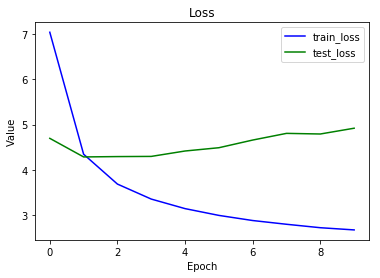

In [20]:
train(model, max_seq_len, label_one_hot, output_vocab, learning_rate, ctx)

## 使用模型进行实体识别

In [37]:
def generate_named_entity(input_vocab, sentence_input, pred, max_seq_len):
    """生成实体，要求 sentence_input 为输入的词的整数化的列表，一维， pre为预测的类别的列表，一维"""
    named_entity = []
    indices = []
    for word_idx in range(max_seq_len):
        if pred[word_idx] == 'C':
            named_entity.append(input_vocab.to_tokens(sentence_input[word_idx]))
        elif pred[word_idx] == 'B':
            if pred[word_idx+1] != 'I' or pred[word_idx+1] != 'E':
                named_entity.append(input_vocab.to_tokens(sentence_input[word_idx]))
                indices.clear()
            else:
                indices.append(word_idx)
        elif pred[word_idx] == 'I':
            if pred[word_idx+1] != 'E' and pred[word_idx+1] != 'I':
                concated_str = ''
                for idx in indices:
                    concated_str += input_vocab.to_tokens(sentence_input[idx])
                named_entity.append(concated_str)
                indices.clear()
            else:
                indices.append(word_idx)
        elif pred[word_idx] == 'E':
            indices.append(word_idx)
            concated_str = ''
            for idx in indices:
                concated_str += input_vocab.to_tokens(sentence_input[idx])
            named_entity.append(concated_str)
            indices.clear()
            
    return named_entity            

In [34]:
def test(model, data_iter_test, test_batch_size, label_one_hot, output_vocab=output_vocab):
    cate_num = label_one_hot.shape[0] -1 
    
    p = np.zeros((cate_num, ))
    r = np.zeros((cate_num, ))
    f1 = np.zeros((cate_num, ))
    
    batch_idx = 0
    for test_x, test_y, nature in data_iter_test:
        batch_preds = []
        expand_batch_p = np.zeros((cate_num, ))
        expand_batch_r = np.zeros((cate_num, ))
        expand_batch_f1 = np.zeros((cate_num, ))
        for word_idx in range(test_x.shape[1]): 
            distance = nd.arange(test_x.shape[1], ctx=ctx) - word_idx
            distance = distance.reshape((1, -1))
            # batch_distance 尺寸: (test_batch_size, max_seq_length)
            batch_distance = nd.broadcast_axis(distance, axis=0, size=test_batch_size)                    
                    
            outputs = model(test_x, nature, batch_distance)
            # preds 代表一个 batch 的第 word_idx 的词的输出，尺寸： (test_batch_size,)
            preds = nd.argmax(nd.softmax(outputs, axis=1), axis=1)
                    
            # 扩展preds 为（test_batch_size, 1) 并添加入列表
            batch_preds.append(nd.expand_dims(preds, axis=1)) 
            
        batch_preds = nd.concat(*batch_preds, dim=1)
        batch_p, batch_r, batch_f1 = cal_scores(batch_preds.asnumpy(), test_y.asnumpy())
        expand_batch_p[0 : batch_p.shape[0]] = batch_p
        expand_batch_r[0 : batch_r.shape[0]] = batch_r
        expand_batch_f1[0 : batch_f1.shape[0]] = batch_f1
        
        batch_idx += 1
        p += expand_batch_p
        r += expand_batch_r
        f1 += expand_batch_f1
        
    p /= batch_idx
    r /= batch_idx
    f1 /= batch_idx 
    print("TestData  : ", output_vocab.idx_to_token[1:])
    print("Precision : ", p)
    print("Recall    : ", r)
    print("F1        : ", f1)

In [35]:
test(model, data_iter_test, batch_size, label_one_hot)

TestData  :  ['N', 'C', 'B', 'E', 'I']
Precision :  [0.97444295 0.93019735 0.85240456 0.84664384 0.82560736]
Recall    :  [0.98635602 0.93072642 0.77595691 0.75128392 0.69676265]
F1        :  [0.98036024 0.93033852 0.81212538 0.79583427 0.75415434]


In [38]:
def predict(model, sentences_input, nature, input_vocab, output_vocab):
    batch_preds = [] 
    for word_idx in range(sentences_input.shape[1]): 
        distance = nd.arange(sentences_input.shape[1], ctx=ctx) - word_idx
        distance = distance.reshape((1, -1))
        batch_distance = nd.broadcast_axis(distance, axis=0, size=sentences_input.shape[0])
        
        outputs = model(sentences_input, nature, batch_distance)
        preds = nd.argmax(nd.softmax(outputs, axis=1), axis=1)
        
        batch_preds.append(nd.expand_dims(preds, axis=1)) 
    batch_preds = nd.concat(*batch_preds, dim=1)
    
    named_entity_ls = []
    for row in range(batch_preds.shape[0]):
        pred_idx = [int(x) for x in list(batch_preds[row].asnumpy())]
        sentence_word_idx = [int(x) for x in list(sentences_input[row].asnumpy())]
        
        pred_label = output_vocab.to_tokens(pred_idx)   
        
        named_entity = generate_named_entity(input_vocab, sentence_word_idx, pred_label, max_seq_len)
        named_entity_ls.append(named_entity)
    return named_entity_ls

In [42]:
sentences_input = nd.array(X_test[10:11], ctx=ctx)
sub_nature = nd.array(nature[10:11], ctx=ctx)

named_entity_pred = predict(model, sentences_input, sub_nature, input_vocab, output_vocab)

for example_idx in range(sentences_input.shape[0]):
    sentece = input_vocab.to_tokens([int(x) for x in sentences_input[example_idx].asnumpy()])
    print("真实的句子：", sentece)
    print("预测的实体: ", named_entity_pred[example_idx])
    print()
    print()

真实的句子： ['10', '合肥市', '第二', '人民', '医院', '15655', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
预测的实体:  ['合肥市', '人民医院']




In [33]:
print(output_vocab.idx_to_token[1:])

['N', 'C', 'B', 'E', 'I']
